In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keras/keras/default/1/keras.model
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/SHA256SUMS.txt
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data.csv
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/RECORDS
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/LICENSE.txt
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/84711.txt
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/50168_MV.wav
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/50746_AV.hea
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/50159_PV.wav
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/85225.txt
/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/85241_PV.hea
/kaggle/input/the-circor-digiscope-phon

**🧩 Data Components:**

Each record (for example, 2530_AV) typically includes:

File Type	Example	Description


**.wav**	2530_AV.wav	The actual heart sound recording (phonocardiogram signal). Mono, 4000 Hz sampling rate, 16-bit.


**.hea**	2530_AV.hea	Header file describing metadata like record name, sampling rate, channels, and label (e.g., AV = Aortic Valve).


**.tsv**	2530_AV.tsv	Annotation file with cardiac cycle segmentation — timestamps for S1, S2, systole, and diastole phases.


****Importing and Exploring the Dataset Folder****

In [2]:
import os

base_path = "/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2"
for root, dirs, files in os.walk(base_path):
    print("Folders:", dirs)
    print("Sample files:", files[:10])
    break


Folders: ['training_data']
Sample files: ['SHA256SUMS.txt', 'training_data.csv', 'RECORDS', 'LICENSE.txt']


****Loading and Cleaning the Metadata****

In [3]:
import pandas as pd

df = pd.read_csv(f"{base_path}/training_data.csv")
print(df.shape)
df.head()

# Keep important columns
df_clean = df[['Patient ID', 'Murmur', 'Locations', 'Age', 'Sex']]
print("Before cleaning:", df_clean.shape)

# Remove missing murmur labels
df_clean = df_clean[df_clean['Murmur'].notna()]
print("After removing missing murmurs:", df_clean.shape)

df_clean.head()


(942, 22)
Before cleaning: (942, 5)
After removing missing murmurs: (942, 5)


,Patient ID,Murmur,Locations,Age,Sex
0,2530,Absent,AV+PV+TV+MV,Child,Female
1,9979,Present,AV+PV+TV+MV,Child,Female
2,9983,Unknown,AV+PV+TV+MV,Child,Male
3,13918,Present,AV+PV+TV+MV,Child,Male
4,14241,Present,AV+PV+TV+MV,Child,Male


****Clean the murmur labels:****

**1 → Murmur present0 → No murmur**


In [4]:
df_clean['Label'] = df_clean['Murmur'].map({'Present': 1, 'Absent': 0})
df_clean = df_clean.dropna(subset=['Label'])
df_clean.head()


,Patient ID,Murmur,Locations,Age,Sex,Label
0,2530,Absent,AV+PV+TV+MV,Child,Female,0.0
1,9979,Present,AV+PV+TV+MV,Child,Female,1.0
3,13918,Present,AV+PV+TV+MV,Child,Male,1.0
4,14241,Present,AV+PV+TV+MV,Child,Male,1.0
5,14998,Absent,AV+PV+TV+MV,Child,Male,0.0


****Map patient IDs to their .wav files****

In [5]:
import os

# Correct base path
base_audio = "/kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data"

file_paths = []

for pid in df_clean['Patient ID']:
    patient_files = [
        os.path.join(base_audio, f)
        for f in os.listdir(base_audio)
        if f.startswith(str(pid)) and f.endswith('.wav')
    ]
    file_paths.append(patient_files)

df_clean['Audio_Files'] = file_paths
df_clean.head()


,Patient ID,Murmur,Locations,Age,Sex,Label,Audio_Files
0,2530,Absent,AV+PV+TV+MV,Child,Female,0.0,[/kaggle/input/the-circor-digiscope-phonocardi...
1,9979,Present,AV+PV+TV+MV,Child,Female,1.0,[/kaggle/input/the-circor-digiscope-phonocardi...
3,13918,Present,AV+PV+TV+MV,Child,Male,1.0,[/kaggle/input/the-circor-digiscope-phonocardi...
4,14241,Present,AV+PV+TV+MV,Child,Male,1.0,[/kaggle/input/the-circor-digiscope-phonocardi...
5,14998,Absent,AV+PV+TV+MV,Child,Male,0.0,[/kaggle/input/the-circor-digiscope-phonocardi...


****Audio Preprocessing****

In [6]:
!pip install librosa soundfile


In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os



**A Mel Spectrogram is a visual representation of sound —it shows how the energy (loudness) of different frequencies changes over time, but on a scale that matches how humans hear.**


In [8]:
def preprocess_audio(file_path, target_sr=2000, n_mels=128):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=target_sr)
        
        # Trim leading/trailing silence
        y, _ = librosa.effects.trim(y)
        
        # Normalize
        y = librosa.util.normalize(y)
        
        # Convert to Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        return mel_spec_db
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


Processing: /kaggle/input/the-circor-digiscope-phonocardiogram-dataset-v2/training_data/training_data/2530_AV.wav


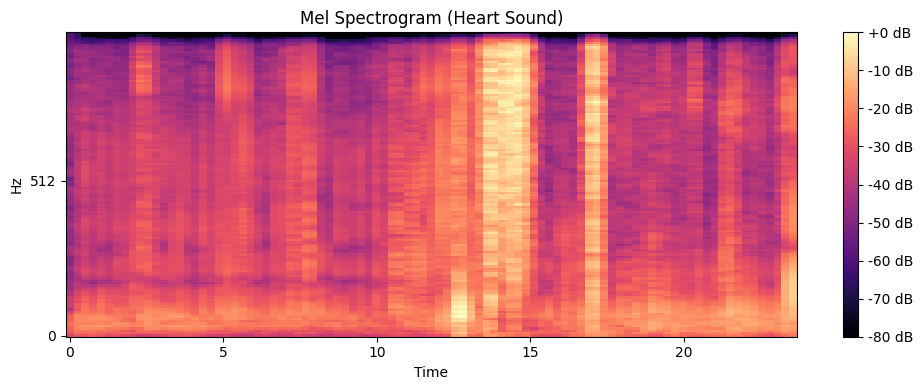

In [9]:
# Pick one sample file
sample_file = df_clean['Audio_Files'].iloc[0][0]
print("Processing:", sample_file)

mel_spectrogram = preprocess_audio(sample_file)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=2000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Heart Sound)')
plt.tight_layout()
plt.show()



**Time → X-axisFrequency → Y-axisLoudness → Color intensity**


**1. **Creating and Preparing the Dataset for Model Training****

****1️⃣ Processing All Audio Files****

In [10]:
all_specs = []
labels = []

for i, row in df_clean.iterrows():
    for wav_file in row['Audio_Files']:
        mel_spec = preprocess_audio(wav_file)
        if mel_spec is not None:
            all_specs.append(mel_spec)
            labels.append(row['Label'])

print(f"✅ Processed {len(all_specs)} audio samples.")


✅ Processed 3007 audio samples.


****2️⃣ Padding Spectrograms and Saving****

In [11]:
import numpy as np

def pad_spectrogram(spec, max_len=400):
    if spec.shape[1] < max_len:
        pad_width = max_len - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        spec = spec[:, :max_len]
    return spec

# Apply padding
max_len = 400
all_specs_padded = [pad_spectrogram(spec, max_len=max_len) for spec in all_specs]

# Convert to array and save
all_specs_array = np.array(all_specs_padded)
np.save('/kaggle/working/mel_specs.npy', all_specs_array)
np.save('/kaggle/working/labels.npy', np.array(labels))

print("✅ Saved padded Mel spectrograms with uniform shape:", all_specs_array.shape)


✅ Saved padded Mel spectrograms with uniform shape: (3007, 128, 400)


→ made sure each image is same size (128×400)
→ now you have 3007 total spectrograms ready for model training.

**3️⃣ Loading the Saved Data**

In [12]:
import numpy as np

mel_specs = np.load('/kaggle/working/mel_specs.npy', allow_pickle=True)
labels = np.load('/kaggle/working/labels.npy', allow_pickle=True)

print("✅ Loaded successfully!")
print("Number of samples:", len(mel_specs))
print("Number of labels:", len(labels))


✅ Loaded successfully!
Number of samples: 3007
Number of labels: 3007


You have 3007 Mel spectrograms (each one is a 2D array image representing a heart sound).

You have 3007 corresponding labels (one per sample).
Each label tells whether that recording is Normal (0) or Murmur (1).

So your features (X) and targets (y) are matched correctly.

****4️⃣ Visualizing Few Spectrograms****

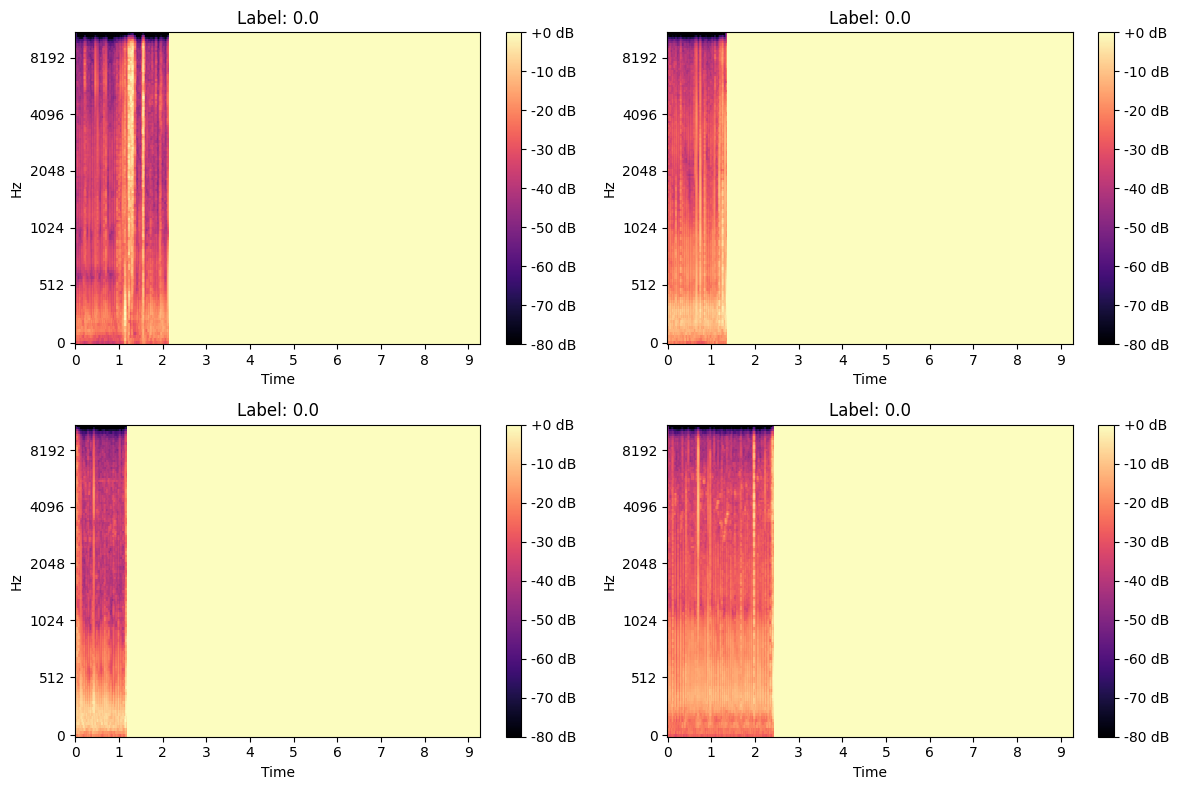

In [13]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    librosa.display.specshow(mel_specs[i], x_axis='time', y_axis='mel', cmap='magma')
    plt.title(f"Label: {labels[i]}")
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


****5️⃣ Checking Label Distribution****

In [14]:
import numpy as np

labels = np.load('/kaggle/working/labels.npy', allow_pickle=True)

unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")


Label 0.0: 2391 samples
Label 1.0: 616 samples


In [15]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-10-29 04:15:53.099088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761711353.336832      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761711353.407314      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [16]:
import tensorflow as tf

# Check TensorFlow version and GPU info
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

# Run a small test
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print("Matrix multiplication successful on GPU ✅")


TensorFlow version: 2.18.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Matrix multiplication successful on GPU ✅


I0000 00:00:1761711367.365997      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761711367.367451      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
!nvidia-smi


Wed Oct 29 04:16:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             27W /   70W |     145MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

****Listing the Files in Your Working Directory****

In [18]:
!ls -lh /kaggle/working/mel_specs.npy
!ls -lh /kaggle/working/labels.npy


-rw-r--r-- 1 root root 588M Oct 29 04:15 /kaggle/working/mel_specs.npy
-rw-r--r-- 1 root root 24K Oct 29 04:15 /kaggle/working/labels.npy


****Loading the Data with NumPy****

In [19]:
import numpy as np

X = np.load('/kaggle/working/mel_specs.npy', allow_pickle=True)
y = np.load('/kaggle/working/labels.npy', allow_pickle=True)

print("Mel Spectrograms:", X.shape)
print("Labels:", len(y))


Mel Spectrograms: (3007, 128, 400)
Labels: 3007


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1️⃣ Load your existing dataset
X_resized = np.load('/kaggle/working/mel_specs.npy')  # shape: (num_samples, 128, 128, 3)
y = np.load('/kaggle/working/labels.npy')             # shape: (num_samples,)

print("Original shapes:", X_resized.shape, y.shape)

# 2️⃣ Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # ensures class distribution is preserved
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)

# 3️⃣ One-hot encode labels
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

print("One-hot encoded shapes:", y_train.shape, y_val.shape)

# 4️⃣ Save arrays for later use
np.save('/kaggle/working/X_train.npy', X_train)
np.save('/kaggle/working/X_val.npy', X_val)
np.save('/kaggle/working/y_train.npy', y_train)
np.save('/kaggle/working/y_val.npy', y_val)

print("✅ Training and validation arrays saved successfully.")


Original shapes: (3007, 128, 400) (3007,)
Train shapes: (2405, 128, 400) (2405,)
Validation shapes: (602, 128, 400) (602,)
One-hot encoded shapes: (2405, 2) (602, 2)
✅ Training and validation arrays saved successfully.


Cy = [0, 1, 0, 0, 1, ...]
TO
y = [[1, 0],
     [0, 1],
     [1, 0], ...]

[1, 0] → Normal (Label 0)

[0, 1] → Abnormal (Label 1)

In [21]:
import cv2

X_resized = []
for mel in X:
    mel_resized = cv2.resize(mel, (128, 128))
    mel_3ch = np.stack([mel_resized]*3, axis=-1)
    X_resized.append(mel_3ch)

X_resized = np.array(X_resized)
y = np.array(y)

print("X shape:", X_resized.shape)


X shape: (3007, 128, 128, 3)


3-CHANNEL RGB OUTPUT


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resized, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
!ls /kaggle/input/resnet50-murmur-model


keras


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



**TRAINING PIPELINE Load Data**


In [25]:
import numpy as np

# Load preprocessed data
X_train = np.load("/kaggle/working/X_train.npy")
X_val = np.load("/kaggle/working/X_val.npy")
y_train = np.load("/kaggle/working/y_train.npy")
y_val = np.load("/kaggle/working/y_val.npy")

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Train shape: (2405, 128, 400) (2405, 2)
Val shape: (602, 128, 400) (602, 2)


**Build Model (Using Pretrained ResNet50)**


*****1️⃣ ResNet is a deep convolutional neural network that uses skip (shortcut) connections to pass information directly across layers.2️⃣ It is built from residual blocks, where the input is added back to the output to prevent information loss and vanishing gradients.3️⃣ This design allows ResNet to train very deep models (like ResNet-50/101) efficiently and achieve high accuracy in image and audio classification tasks.*****



In [26]:
import os

# List all files in the current folder
os.listdir('.')


['mel_specs.npy',
 'X_train.npy',
 '.virtual_documents',
 'y_val.npy',
 'y_train.npy',
 'X_val.npy',
 'labels.npy']

In [27]:
# Ensure 3-channel input for ResNet50
if X_train.shape[-1] == 1:  # grayscale → RGB
    X_train = np.repeat(X_train, 3, axis=-1)
    X_val   = np.repeat(X_val, 3, axis=-1)

print("✅ Updated X_train shape:", X_train.shape)


✅ Updated X_train shape: (2405, 128, 400)


In [35]:
# ============================================================
# ✅ FINAL HIGH-ACCURACY RESNET50 MODEL (Imbalance + Mixup + SpecAugment)
# ============================================================

# ------------------------------
# 1️⃣ Imports
# ------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import random

# ------------------------------
# 2️⃣ Load Data
# ------------------------------
X_train = np.load('/kaggle/working/X_train.npy')
X_val   = np.load('/kaggle/working/X_val.npy')
y_train = np.load('/kaggle/working/y_train.npy')
y_val   = np.load('/kaggle/working/y_val.npy')

print("✅ Data loaded successfully")
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# Add channel dimension if missing
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

# Convert grayscale → RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)

# Resize for ResNet50 input
X_train = tf.image.resize(X_train, [224, 224]).numpy()
X_val = tf.image.resize(X_val, [224, 224]).numpy()

print(f"✅ Shapes fixed for ResNet: {X_train.shape}")

# ------------------------------
# 3️⃣ Show Class Distribution
# ------------------------------
print("Label distribution:")
print(f"Label 0.0: {(y_train[:,0] == 1).sum()} samples")
print(f"Label 1.0: {(y_train[:,1] == 1).sum()} samples")

# ------------------------------
# 4️⃣ SpecAugment (for audio spectrograms)
# ------------------------------
def spec_augment(mel_spectrogram):
    spec = mel_spectrogram.copy()
    # Frequency masking
    f = np.random.randint(0, 15)
    f0 = np.random.randint(0, spec.shape[0] - f)
    spec[f0:f0+f, :] = 0
    # Time masking
    t = np.random.randint(0, 40)
    t0 = np.random.randint(0, spec.shape[1] - t)
    spec[:, t0:t0+t] = 0
    return spec

# ------------------------------
# 5️⃣ Mixup + Balanced Oversampling Generator
# ------------------------------
def mixup(x1, y1, x2, y2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

def balanced_generator(X, y, batch_size=32):
    idx_majority = np.where(np.argmax(y, axis=1) == 0)[0]
    idx_minority = np.where(np.argmax(y, axis=1) == 1)[0]
    
    while True:
        x_batch, y_batch = [], []
        for _ in range(batch_size):
            # Equal sampling from both classes
            if random.random() < 0.5:
                idx = np.random.choice(idx_minority)
            else:
                idx = np.random.choice(idx_majority)
            img, label = X[idx], y[idx]

            # SpecAugment (applied on grayscale slice)
            img_aug = spec_augment(img[:, :, 0])
            img_aug = np.repeat(img_aug[..., np.newaxis], 3, axis=-1)

            # Mixup with another random sample
            idx2 = np.random.randint(0, len(X))
            img2, label2 = X[idx2], y[idx2]
            img_final, label_final = mixup(img_aug, label, img2, label2)

            x_batch.append(img_final)
            y_batch.append(label_final)
        
        yield np.array(x_batch), np.array(y_batch)

train_gen = balanced_generator(X_train, y_train, batch_size=32)
val_gen = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# ------------------------------
# 6️⃣ Build Model
# ------------------------------
base_model = ResNet50(
    weights='/kaggle/input/resnet50-murmur-model/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze early layers, fine-tune last 60
for layer in base_model.layers[:-60]:
    layer.trainable = False
for layer in base_model.layers[-60:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# ------------------------------
# 7️⃣ Compile + LR Scheduler
# ------------------------------
initial_lr = 3e-4
def cosine_decay(epoch):
    return 0.5 * initial_lr * (1 + np.cos(np.pi * epoch / 60))

lr_scheduler = LearningRateScheduler(cosine_decay)

optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------------------
# 8️⃣ Callbacks
# ------------------------------
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_resnet_final.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

# ------------------------------
# 9️⃣ Train Model
# ------------------------------
steps_per_epoch = len(X_train) // 32

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=70,
    callbacks=[early_stop, reduce_lr, checkpoint, lr_scheduler],
    verbose=1
)

# ------------------------------
# 🔟 Evaluate
# ------------------------------
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n🎯 Final Validation Accuracy: {val_acc * 100:.2f}%")


✅ Data loaded successfully
Train shape: (2405, 128, 400), Validation shape: (602, 128, 400)
✅ Shapes fixed for ResNet: (2405, 224, 224, 3)
Label distribution:
Label 0.0: 1912 samples
Label 1.0: 493 samples
Epoch 1/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6322 - loss: 0.7543
Epoch 1: val_accuracy improved from -inf to 0.82724, saving model to best_resnet_final.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.6328 - loss: 0.7532 - val_accuracy: 0.8272 - val_loss: 0.4467 - learning_rate: 3.0000e-04
Epoch 2/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7178 - loss: 0.5874
Epoch 2: val_accuracy improved from 0.82724 to 0.83056, saving model to best_resnet_final.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.7180 - loss: 0.5872 - val_accuracy: 0.8306 - val_loss: 0.4811 - learning_rate: 2.9979e-04
Epoch 3/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7361 - loss: 0.5842
Epoch 3: val_accuracy improved from 0.83056 to 0.84219,

In [36]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import numpy as np

# Get model predictions
y_pred_proba = model.predict(val_gen)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step


In [37]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

sensitivity = tp / (tp + fn)  # Recall or True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
ppv = tp / (tp + fp)          # Positive Predictive Value
roc_auc = roc_auc_score(y_true, y_pred_proba[:,1])

print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV: {ppv:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")


Sensitivity: 0.301
Specificity: 0.992
PPV: 0.902
ROC AUC: 0.752


Sensitivity: Measures how well the model correctly detects abnormal (murmur) heart sounds.

Specificity: Measures how accurately the model identifies normal heart sounds.

PPV (Positive Predictive Value): Shows how often the model’s “abnormal” predictions are actually correct.

ROC AUC: Indicates the model’s overall ability to distinguish between normal and abnormal heart sounds.

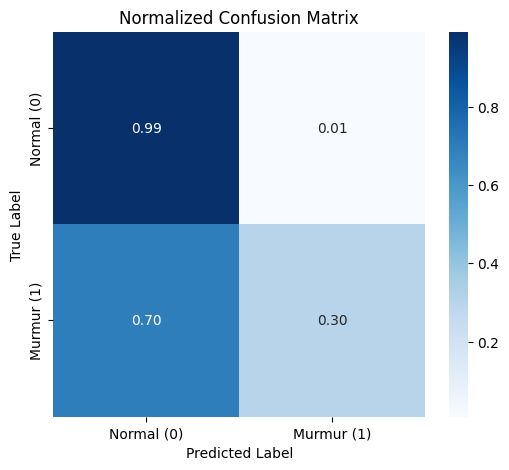

Confusion Matrix (Counts):
[[475   4]
 [ 86  37]]


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Normal (0)", "Murmur (1)"]

# Normalize to get percentages
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Also print raw counts
print("Confusion Matrix (Counts):")
print(cm)


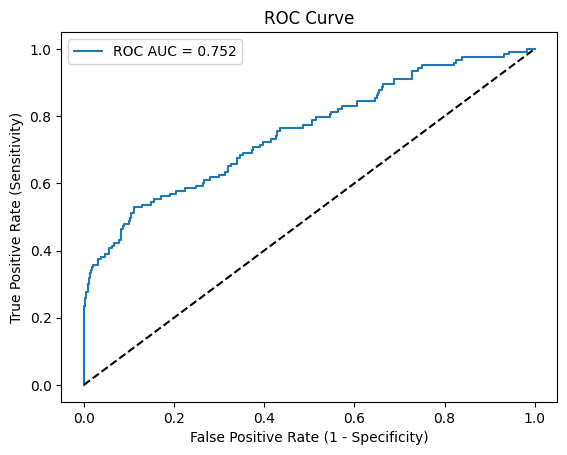

In [39]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend()
plt.show()
